## Легенда

У нас интернет-магазин «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, _Xbox_ или _PlayStation_). Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируем ли мы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

## Изучим общую информацию

In [1]:
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind

In [2]:
data = pd.read_csv("https://code.s3.yandex.net/datasets/games.csv")

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


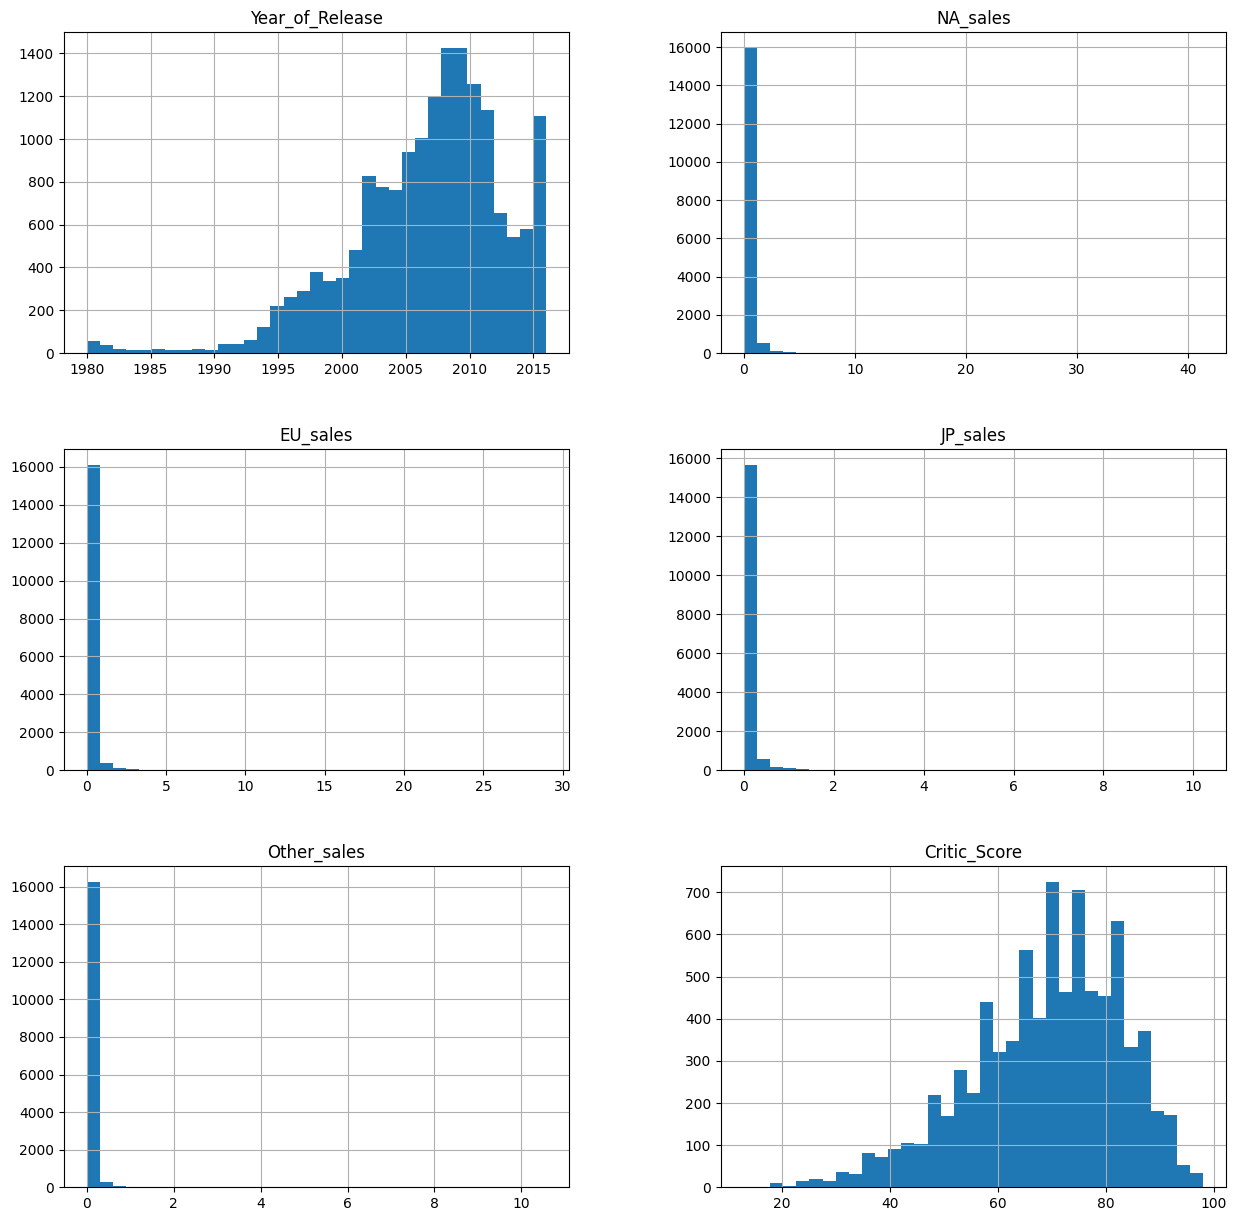

In [6]:
data.hist(figsize=(15, 15), bins=35);

Выведем % пропущенных значений для каждого столбца

In [7]:
(data.isna().mean().sort_values(ascending=False) * 100).round(2)

Critic_Score       51.32
Rating             40.48
User_Score         40.09
Year_of_Release     1.61
Name                0.01
Genre               0.01
Platform            0.00
NA_sales            0.00
EU_sales            0.00
JP_sales            0.00
Other_sales         0.00
dtype: float64

**Вывод**  
В данных много пропусков в трех столбцах, мы видим быстрой рост рынка с 1990 по 2010 годы и неравномерность продаж.

## Подготовим данные

### Заменим названия столбцов

In [8]:
data.columns = data.columns.str.lower()

In [9]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Обработаем пропуски и преобразуем типы данных

В категориальных столбцах `rating`, `name`, `genre` заменим пропуски на `unknown`

In [10]:
data["name"] = data["name"].fillna("unknown")

data["genre"] = data["genre"].fillna("unknown")

data["rating"] = data["rating"].fillna("unknown")

data["year_of_release"] = data["year_of_release"].fillna(0).astype(int)

In [11]:
data["user_score"].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В столбце `user_score` имеется значение `tbd` что означает to be determined: недостаточно пользовательских оценок для формирования рейтинга. Заменим на `Nan`

In [12]:
data["user_score"] = data["user_score"].replace("tbd", np.nan)

In [13]:
(data.isna().mean().sort_values(ascending=False) * 100).round(2)

user_score         54.59
critic_score       51.32
name                0.00
platform            0.00
year_of_release     0.00
genre               0.00
na_sales            0.00
eu_sales            0.00
jp_sales            0.00
other_sales         0.00
rating              0.00
dtype: float64

user_score и critic_score не трогаем

### Добавим столбец с суммарными продажами во всех регионах

In [14]:
data["total_sales"] = data["na_sales"] + data["eu_sales"] + data["jp_sales"] + data["other_sales"]
data.head(1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54


## Проведем исследовательский анализ данных

### Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [15]:
data["year_of_release"].unique()

array([2006, 1985, 2008, 2009, 1996, 1989, 1984, 2005, 1999, 2007, 2010,
       2013, 2004, 1990, 1988, 2002, 2001, 2011, 1998, 2015, 2012, 2014,
       1992, 1997, 1993, 1994, 1982, 2016, 2003, 1986, 2000,    0, 1995,
       1991, 1981, 1987, 1980, 1983])

построим график

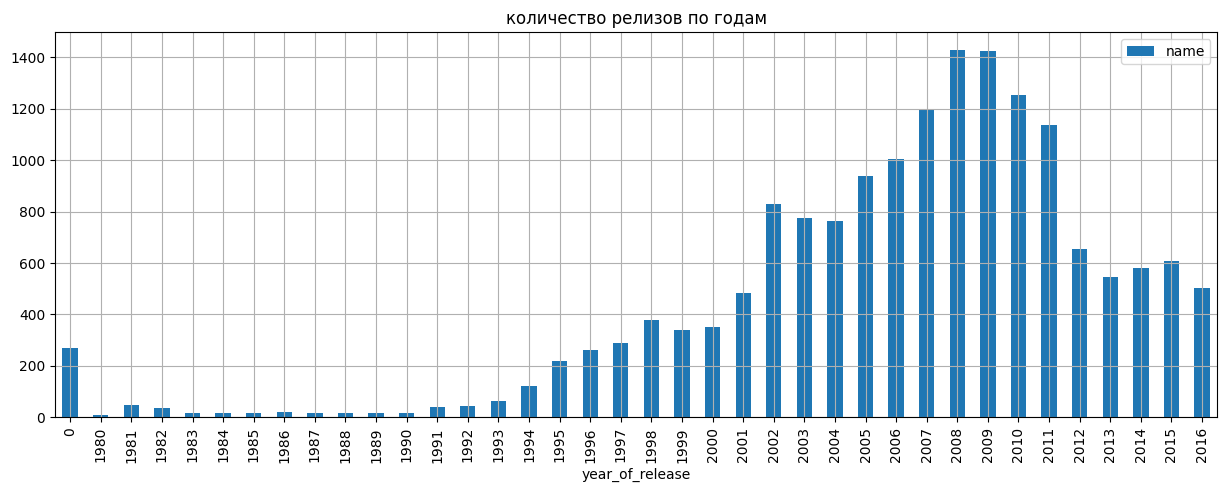

In [16]:
year_count = data \
    .pivot_table(index="year_of_release", values="name", aggfunc="count") \
    .reset_index()
year_count.plot(x="year_of_release", y="name", kind="bar", figsize=(15,5),
                title="количество релизов по годам", grid=True);

На графике мы видим рост количества выпускаемых игр до 2008 года, с 2010 по 2013 годы мы видим спад (в результате масштабного кризиса на американском рынке, многие студии и издательства закрылись), индустрия была в кризисе. 2013 год стал переломным, появился рост. Данные за 2016 год неполные, динамику мы не знаем. Для нашего исследования мы сделаем срез данных с 2012 по 2016 годы, так-как рынок очень быстро меняется и более ранние данные могут исказить прогноз на 2017 год.

### Посмотрим, как менялись продажи по платформам

In [17]:
sales_by_platform = pd.pivot_table(data
                                   , index="year_of_release"
                                   , columns="platform"
                                   , values="total_sales"
                                   , aggfunc="sum")
sales_by_platform.head()

platform,2600,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,...,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,,,,,,
0,10.50,NaN,1.19,NaN,3.34,1.03,4.97,2.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,16.33,NaN,10.18,6.17,NaN
1980,11.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981,35.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982,28.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983,5.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


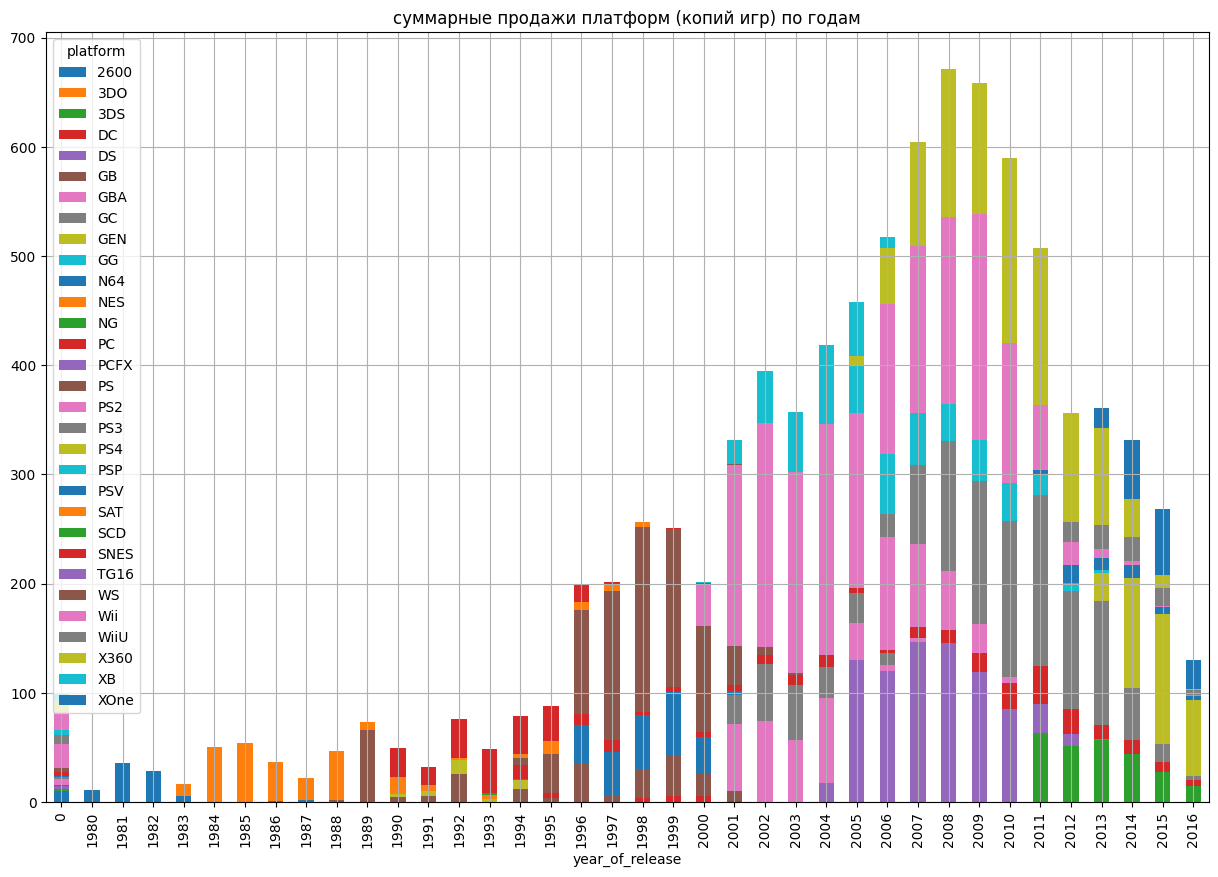

In [18]:
sales_by_platform.plot( kind="bar", figsize=(15,10), title="суммарные продажи платформ (копий игр) по годам", stacked=True, grid=True);

Посмотрим на строки с неизвестным годом

In [19]:
sales_by_platform.loc[[2012, 2013, 2014, 2015, 2016, 0]].dropna(axis='columns',how='all')

platform,2600,3DS,DS,GB,GBA,GC,N64,PC,PS,PS2,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,,,,
2012,NaN,51.36,11.01,NaN,NaN,NaN,NaN,23.22,NaN,NaN,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN,NaN
2013,NaN,56.57,1.54,NaN,NaN,NaN,NaN,12.38,NaN,NaN,113.25,25.99,3.14,10.59,8.59,21.65,88.58,NaN,18.96
2014,NaN,43.76,NaN,NaN,NaN,NaN,NaN,13.28,NaN,NaN,47.76,100.00,0.24,11.90,3.75,22.03,34.74,NaN,54.07
2015,NaN,27.78,NaN,NaN,NaN,NaN,NaN,8.52,NaN,NaN,16.82,118.90,0.12,6.25,1.14,16.35,11.96,NaN,60.14
2016,NaN,15.14,NaN,NaN,NaN,NaN,NaN,5.25,NaN,NaN,3.60,69.25,NaN,4.25,0.18,4.60,1.52,NaN,26.15
0,10.5,1.19,3.34,1.03,4.97,2.2,0.67,3.76,3.28,22.21,8.31,NaN,4.52,0.26,16.33,NaN,10.18,6.17,NaN


Многовато платформ, тяжело разобрать тенденции, отберем самые успешные платформы.  В строках с пропусками в дате мы не видим актуальных платформ, можем их также отбросить.

Выведем топ-10 платформ по суммарным продажам:

In [20]:
top_platform = pd.pivot_table(data, index="platform",  values="total_sales", aggfunc="sum") \
                    .sort_values(by="total_sales", ascending=False).head(10)
top_platform.T

platform,PS2,X360,PS3,Wii,DS,PS,GBA,PS4,PSP,PC
total_sales,1255.77,971.42,939.65,907.51,806.12,730.86,317.85,314.14,294.05,259.52


In [21]:
sales_by_platform_top = pd.pivot_table(data.loc[data["platform"]
                        .isin(top_platform.index) ],
                        index="year_of_release", columns="platform", values="total_sales", aggfunc="sum")

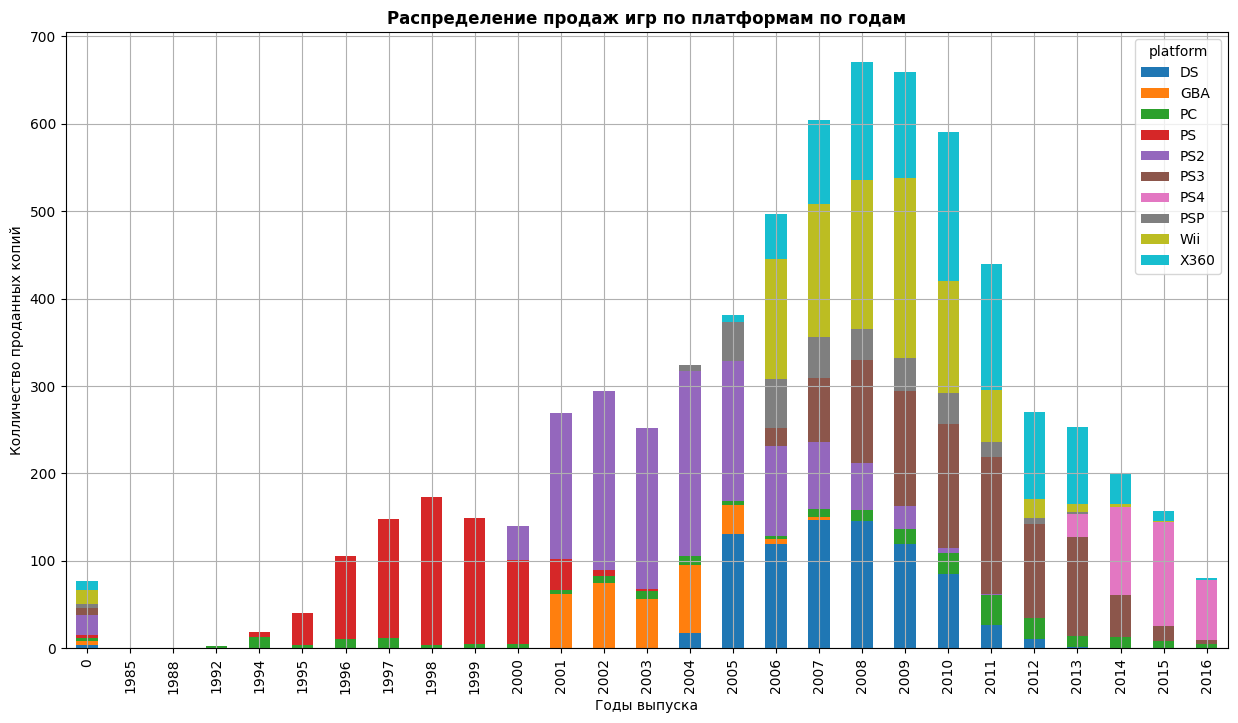

In [22]:
sales_by_platform_top.plot( kind="bar", figsize=(15,8), title="суммарные продажи игр топ-10 платформ по годам",
                           stacked=True, grid=True)
plt.title('Распределение продаж игр по платформам по годам', fontweight="bold")
plt.xlabel('Годы выпуска')
plt.ylabel('Колличество проданных копий')
plt.show()

По графику мы можем сделать вывод: срок коммерческой жизни платформ 5-7 лет, примем актуальный период равным 5 годам.

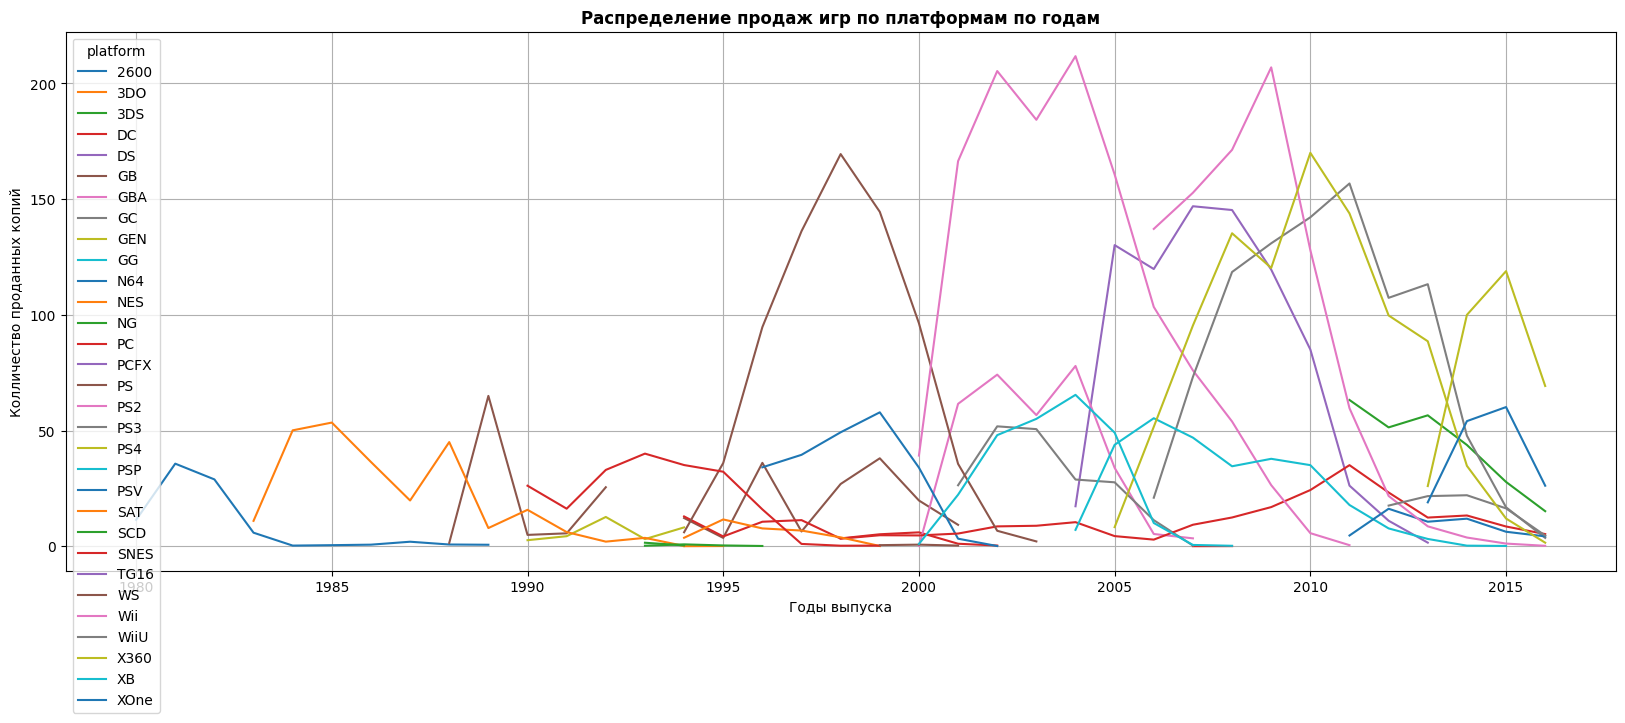

In [23]:
# выделили топ10 платформ
test_top = (data.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum').reset_index()
                .sort_values(by = 'total_sales', ascending = False).head(10))['platform']

(data
    .query('platform in @test_top' and 'year_of_release > 1')
    .pivot_table(index=['year_of_release'], columns='platform', values=['total_sales'], aggfunc='sum')
    .reset_index()
    .plot(x='year_of_release', y='total_sales', kind='line', grid=True, figsize=(20, 7))
)

plt.title('Распределение продаж игр по платформам по годам', fontweight="bold")
plt.xlabel('Годы выпуска')
plt.ylabel('Колличество проданных копий')
plt.show()

### Исследуем данные за 2012 - 2016 годы

In [24]:
data_fil_2012 = data.loc[data["year_of_release"] > 2011]
data_fil_2012.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,unknown,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


In [25]:
sales_filtr = pd.pivot_table(data_fil_2012,
                        index="year_of_release", columns="platform", values="total_sales", aggfunc="sum")

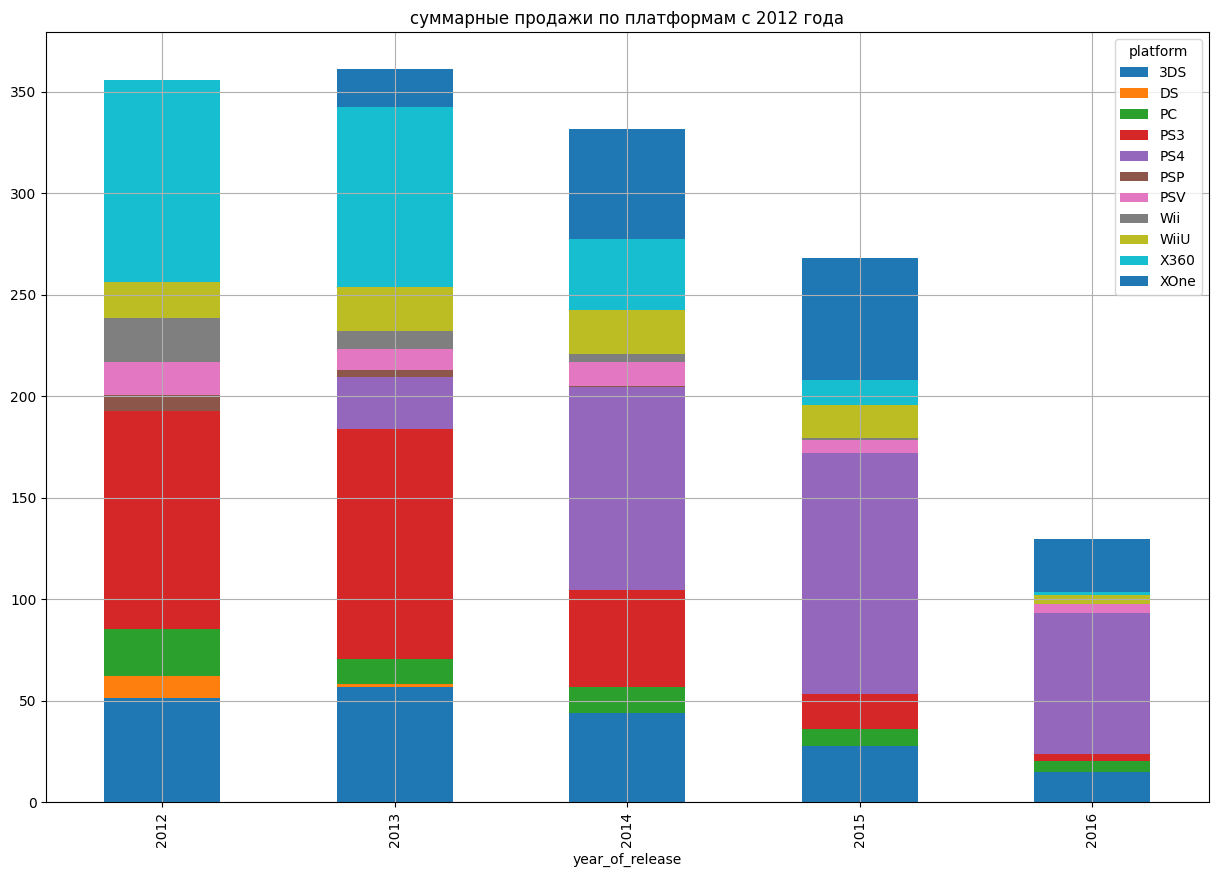

In [26]:
sales_filtr.plot( kind="bar", figsize=(15,10), title="суммарные продажи по платформам c 2012 года", stacked=True, grid=True);

На графике мы видим двух лидеров PS4 и XOne, они вышли в 2013 году, вероятно в 2017-2018 годах они также будут лидерами продаж. Третья по продажам платформа Nintendo 3DS вышла в 2011 году и уже заканчивает свой жизненный цикл.  
Выберем несколько потенциально прибыльных платформ: 3DS, PC, PS4, XOne, WiiU, PSV

### Построем график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

In [27]:
list_platform_6 = ["3DS", "PC", "PS4", "XOne", "WiiU", "PSV"]

In [28]:
df_platform_6 = data_fil_2012.loc[data_fil_2012["platform"].isin(list_platform_6)]

In [29]:
df_platform_6.shape

(1843, 12)

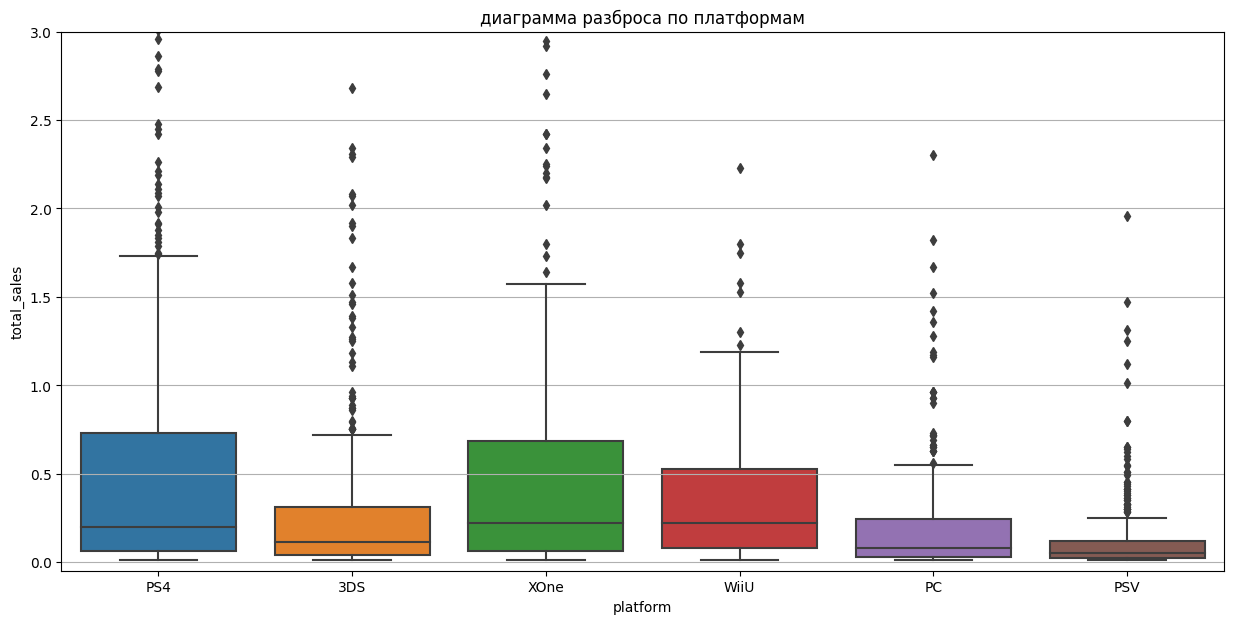

In [30]:
plt.figure(figsize=(15, 7))
plt.ylim(bottom=-0.05, top=3)
plt.grid()
sns.boxplot(data=df_platform_6, x="platform", y="total_sales")
plt.title('диаграмма разброса по платформам');

Мы видим очень большой разброс между топовыми играми и медианным значением. Вероятно большая часть игр не окупается, и издатели покрывают убытки от них сверхприбылью от особо удачных игр.

### Диаграмма рассеяния и корреляция между отзывами и продажами

#### Влияние на продажи внутри одной популярной платформы отзывов пользователей и критиков

Подготовим срез по PS4:

In [31]:
df_ps4 = df_platform_6.loc[(df_platform_6["platform"] == "PS4")].dropna(subset=["critic_score", "user_score"])

In [32]:
df_ps4["critic_score"] = df_ps4["critic_score"].astype(int)
df_ps4["user_score"] = df_ps4["user_score"].astype(float)

Построим диаграмму рассеяния между отзывами и продажами

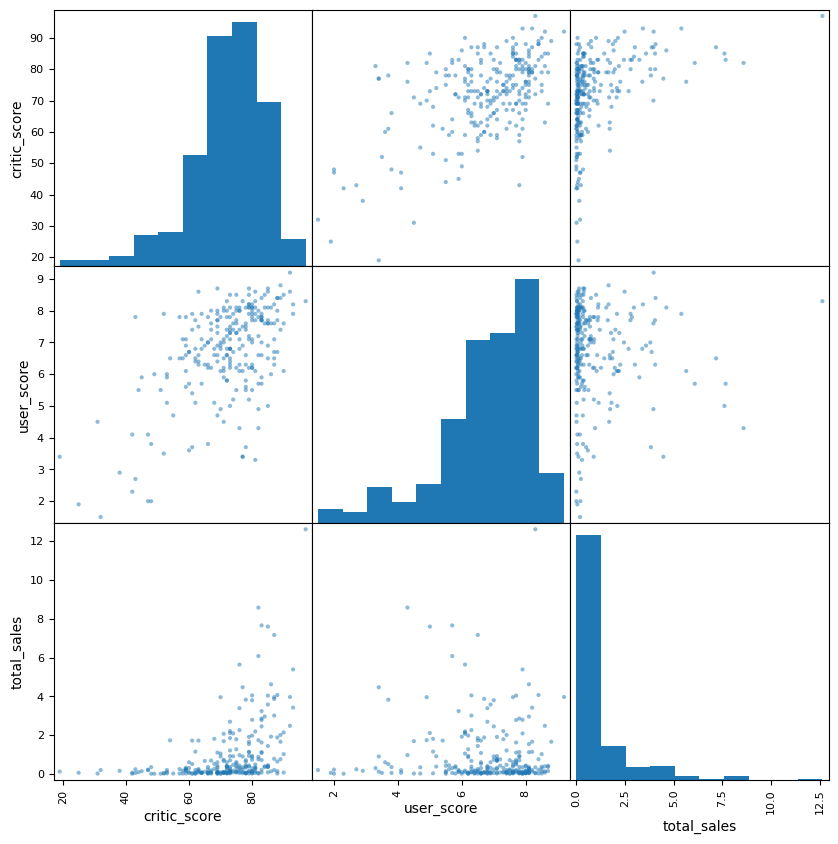

In [33]:
pd.plotting.scatter_matrix(df_ps4.loc[:, ["critic_score", "user_score", "total_sales"]], figsize=(10, 10));

Улучшенный вариант:

Создадим функцию

In [34]:
def func_scatter(platform):
    df = df_platform_6.loc[(df_platform_6["platform"] == platform)].dropna(subset=["critic_score", "user_score"])
    df["critic_score"] = df["critic_score"].astype(int)
    df["user_score"] = df["user_score"].astype(float)
    
    #  Создаем "Figure" и "Axes":
    fig, ax = plt.subplots(nrows = 1, ncols =2 )

    #  Методы, отображающие данные:
    ax[0].scatter(df["critic_score"], df["total_sales"], alpha=0.5)
    ax[1].scatter(df["user_score"], df["total_sales"], alpha=0.5)

    ax[0].grid()
    ax[1].grid()
    #  Заголовок области Figure:
    fig.suptitle(f'Графики зависимости продаж платформы {platform} от рейтингов',
                 fontsize = 15)

    #  Добавление заголовков:
    ax[0].set(title = 'Зависимость продаж от рейтинга критиков')
    ax[1].set(title = 'Зависимость продаж от рейтинга пользователей')

    #  Добавляем подписи к осям:
    ax[0].set_xlabel('рейтинг')
    ax[0].set_ylabel('продажи, млн.шт.')
    ax[1].set_xlabel('рейтинг')
    ax[1].set_ylabel('продажи, млн.шт.')

    fig.set_figwidth(15)    #  ширина и
    fig.set_figheight(5)    #  высота "Figure"

    plt.show()

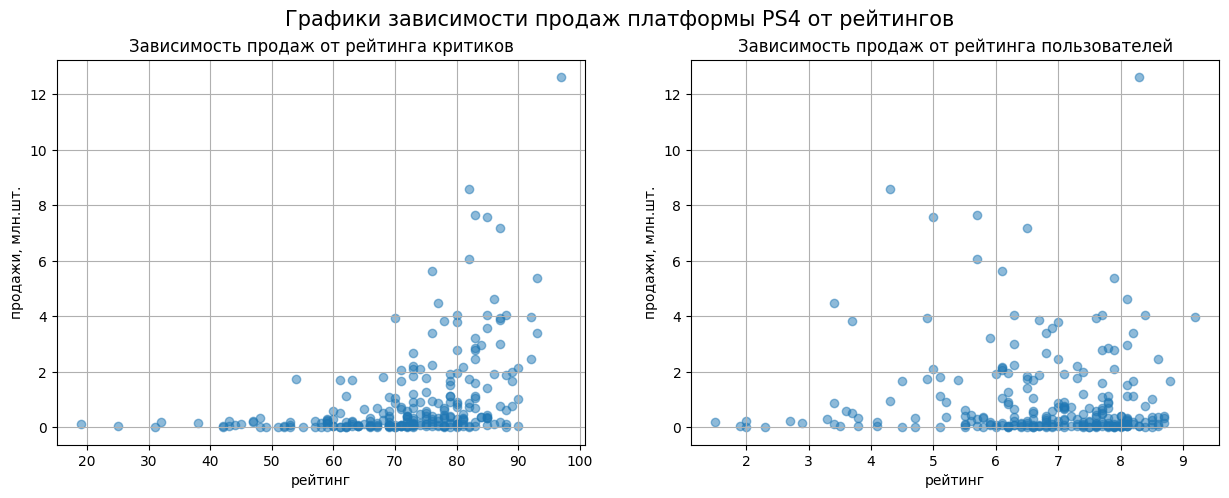

In [35]:
func_scatter("PS4")

Посчитаем корреляцию между отзывами и продажами

In [36]:
df_ps4["user_score"].corr(df_ps4["total_sales"]).round(2)

-0.03

In [37]:
df_ps4["critic_score"].corr(df_ps4["total_sales"]).round(2)

0.41

**Вывод**  
Корреляция с оценкой критиков слабая, а по пользователям вообще отсутствует.  
Это подтверждается на графиках.  
Высокий рейтинг критиков не гарантирует высокие продажи, но у игр с рейтингом меньше 60 очень мало шансов на большой объем продаж. 

### Соотнесем выводы с продажами игр на других платформах

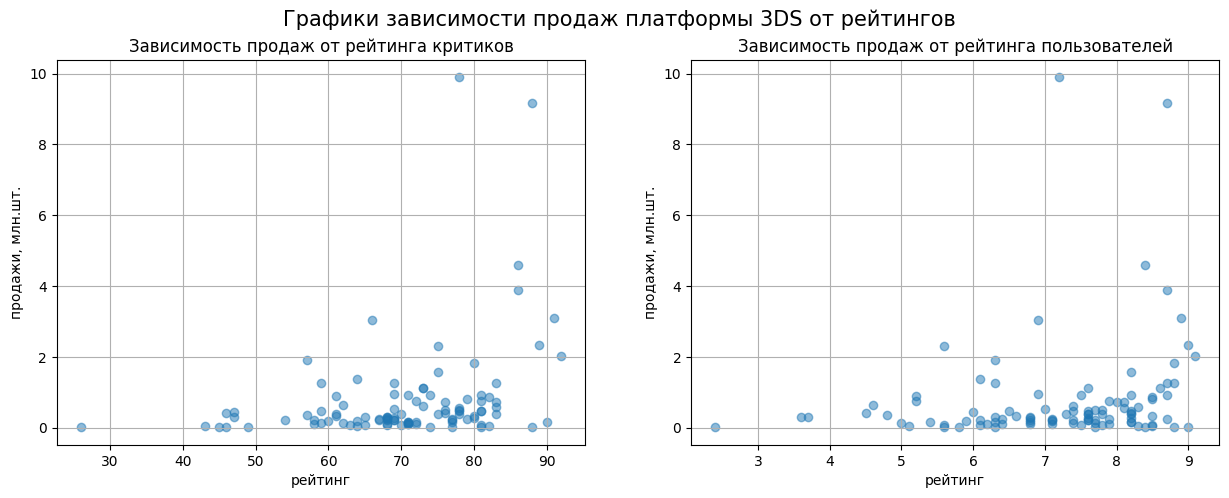

In [38]:
func_scatter("3DS")

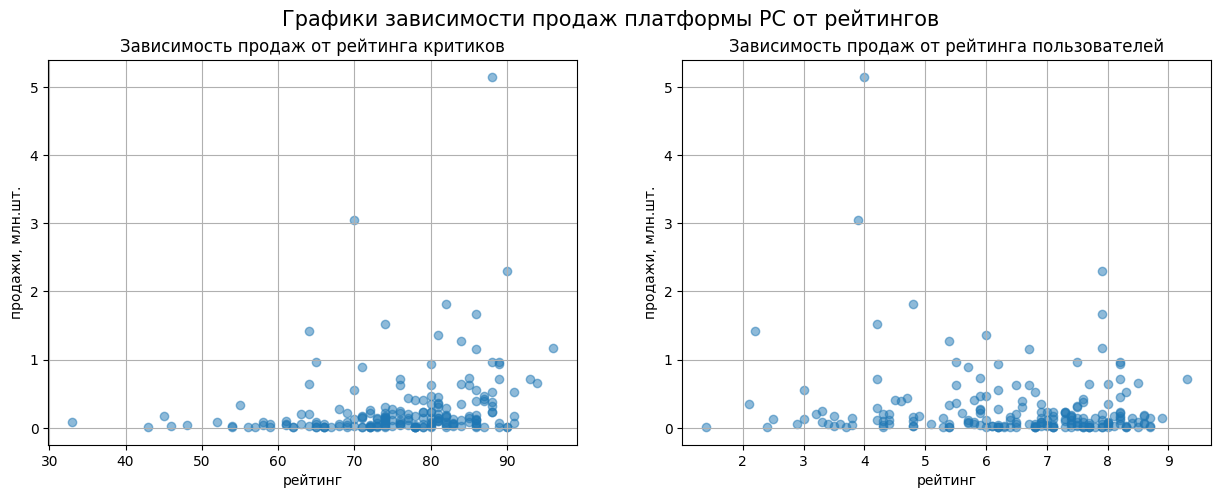

In [39]:
func_scatter("PC")

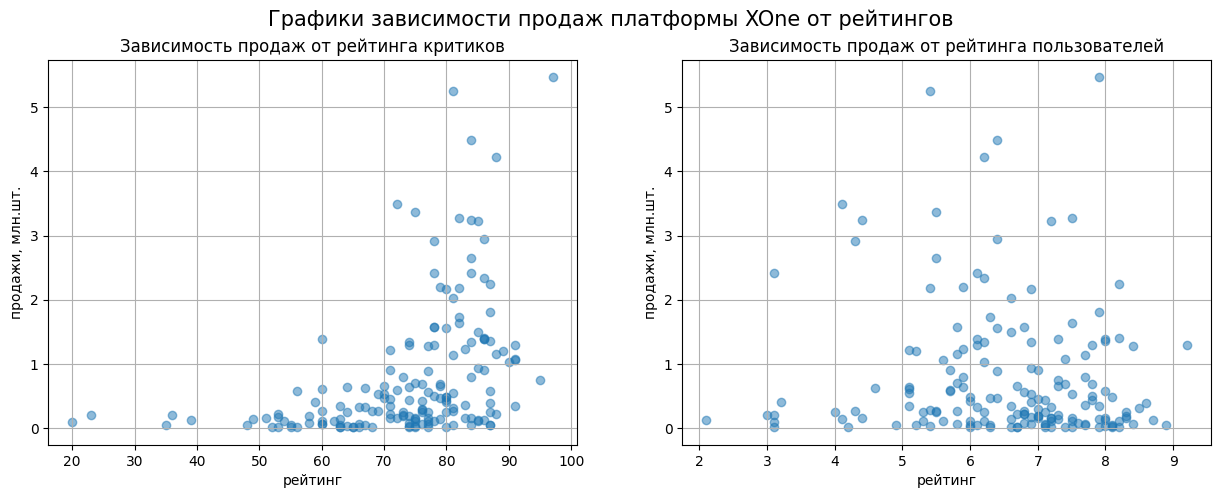

In [40]:
func_scatter("XOne")

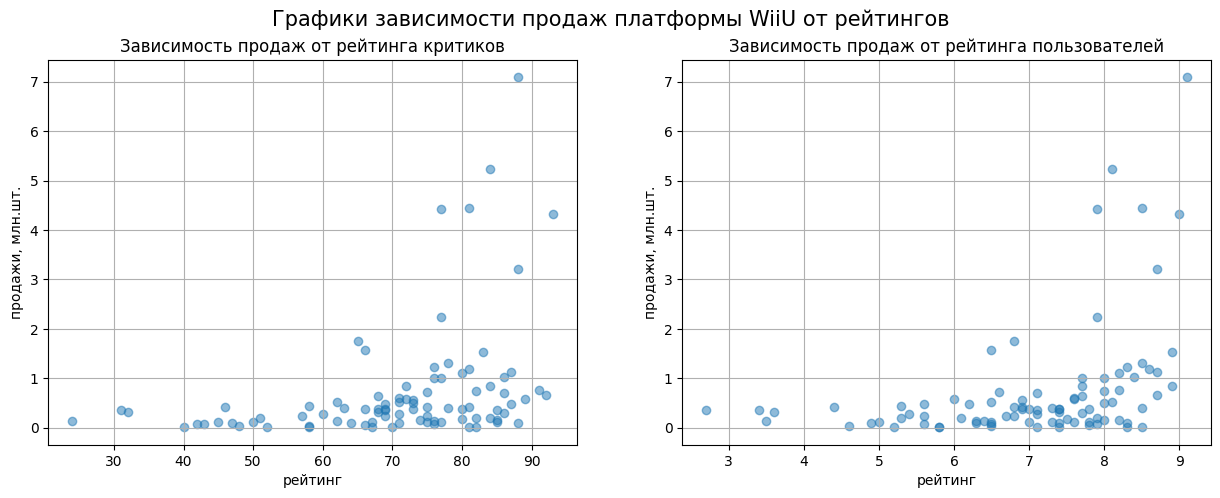

In [41]:
func_scatter("WiiU")

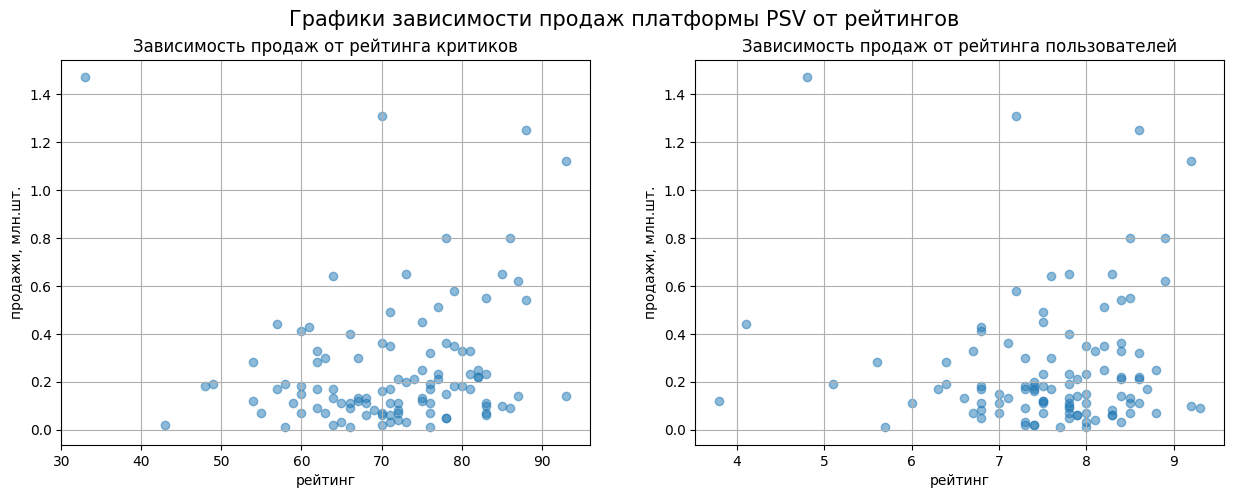

In [42]:
func_scatter("PSV")

#### Сделаем хитмапы корреляций по всем платформам

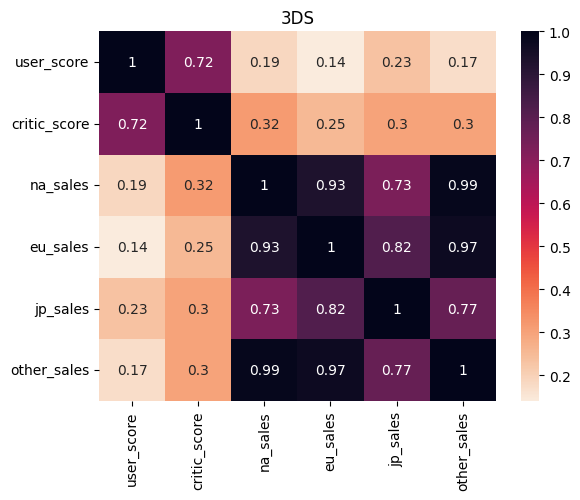

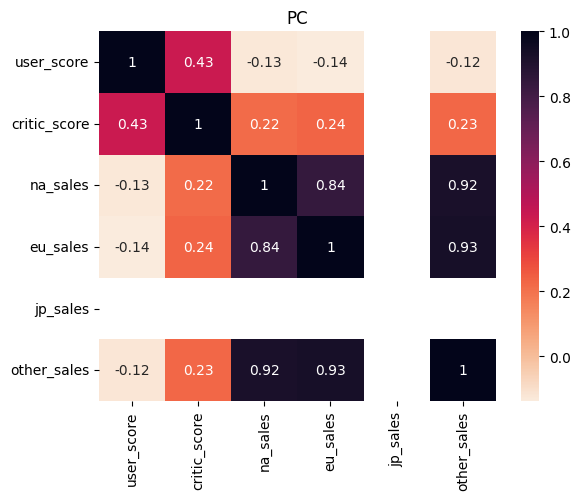

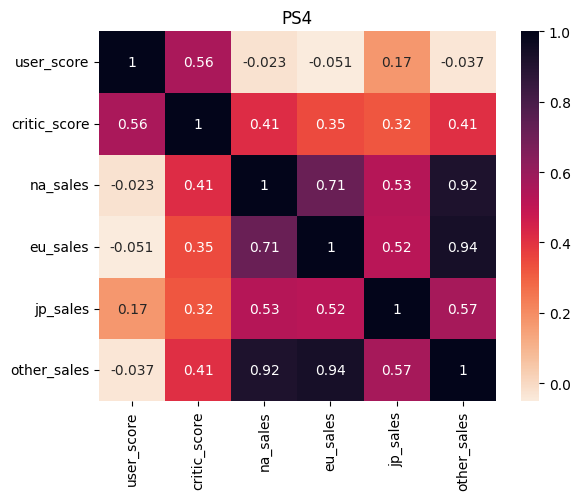

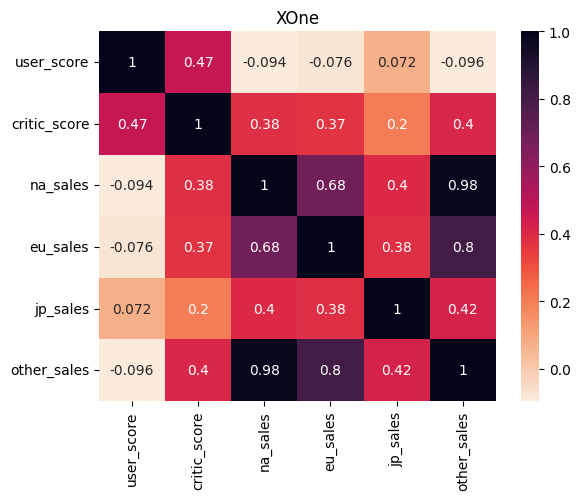

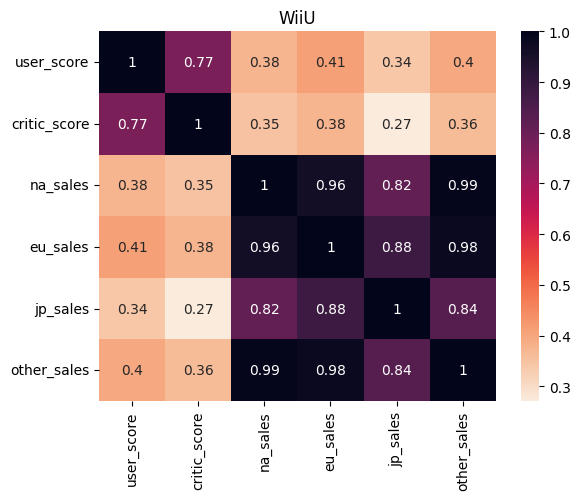

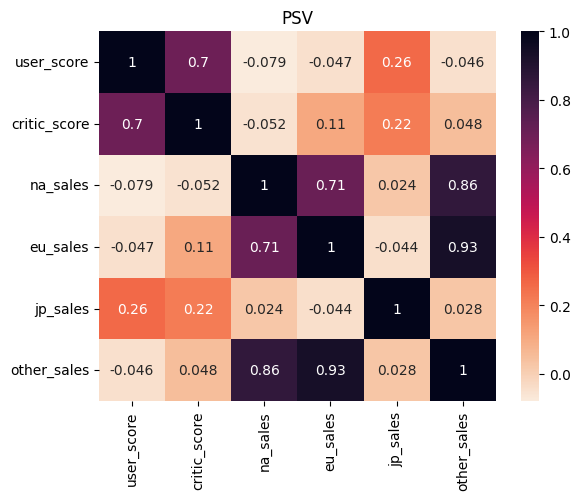

In [43]:
cols = ["user_score", "critic_score", "na_sales", "eu_sales", "jp_sales", "other_sales"]

for platform in list_platform_6:
    df = df_platform_6.loc[df_platform_6["platform"] == platform].dropna(subset=cols)
    df["user_score"] = df["user_score"].astype(float)
    correlations = df[cols].corr()
    ax = sns.heatmap(correlations, cmap="rocket_r", annot = True)
    ax.set_title(platform)
    plt.show()

Тенденции схожи с избранной платформой.

### Посмотрим на общее распределение игр по жанрам

Построим сводную таблицу

In [44]:
genre_agg = data_fil_2012.pivot_table(index='genre', values='total_sales', aggfunc=['sum', 'count', 'mean'])
genre_agg.columns = genre_agg.columns.droplevel(1)
genre_agg.head()

,sum,count,mean
genre,,,
Action,441.12,1031,0.427856
Adventure,29.43,302,0.097450
Fighting,44.49,109,0.408165
Misc,85.04,192,0.442917
Platform,61.00,85,0.717647


Построим графики распределения игр по жанрам

In [45]:
genre_agg.sort_values(by='count', inplace=True)

Через круговую диаграмму:

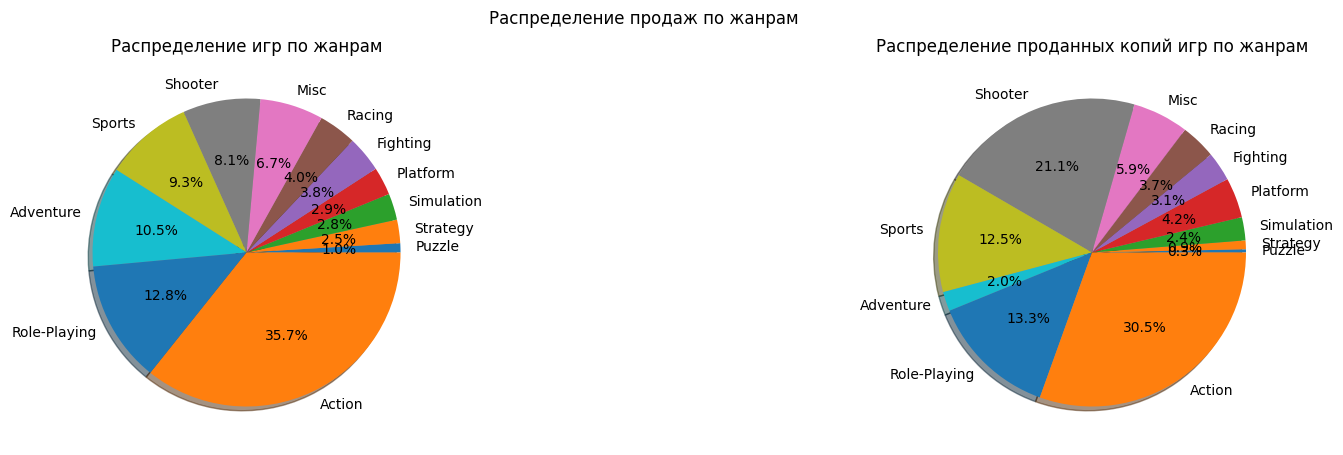

In [46]:
# подписи к графикам
titles = ["Распределение игр по жанрам", "Распределение проданных копий игр по жанрам"]

# столбцы сводной таблиы, по которым строим диаграммы
columns =["count", "sum"]

# определяем области для отрисовки графиков (1 строка, 3 столбца, размер (20 x 10))
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# отрисовываем продажи для каждого региона по отдельности
for ax, col, title in zip(axes, columns, titles):
    genre_agg.plot.pie(y=col, legend=False, ylabel="", 
                   autopct='%1.1f%%',
                   shadow=True, startangle=0, figsize=(20,5), title=title, ax=ax);
    
# добавляем подпись ко всему графику
plt.suptitle("Распределение продаж по жанрам");

Через столбчатую диаграмму:

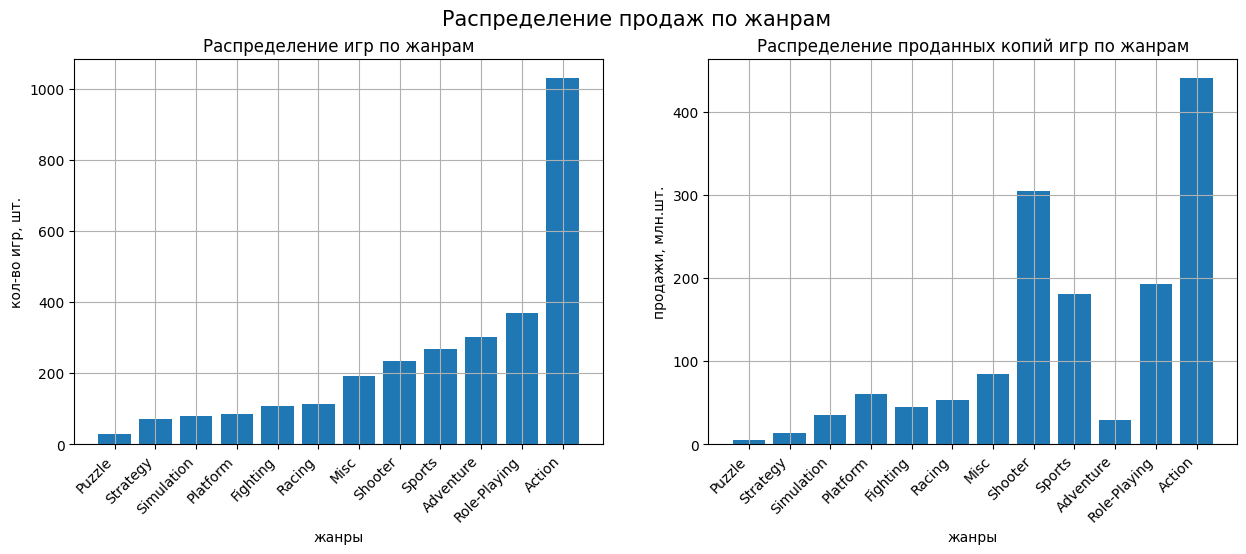

In [47]:
    #  Создаем "Figure" и "Axes":
    fig, ax = plt.subplots(nrows = 1, ncols =2 )

    #  Методы, отображающие данные:
    ax[0].bar(genre_agg.index, genre_agg["count"])
    ax[1].bar(genre_agg.index, genre_agg["sum"])
    ax[0].set_xticks(genre_agg.index)
    ax[0].set_xticklabels(genre_agg.index, rotation=45, ha='right')
    ax[1].set_xticks(genre_agg.index)
    ax[1].set_xticklabels(genre_agg.index, rotation=45, ha='right')
    ax[0].grid()
    ax[1].grid()
    #  Заголовок области Figure:
    fig.suptitle('Распределение продаж по жанрам',
                 fontsize = 15)

    #  Добавление заголовков:
    ax[0].set(title = 'Распределение игр по жанрам')
    ax[1].set(title = 'Распределение проданных копий игр по жанрам')

    #  Добавляем подписи к осям:
    ax[0].set_xlabel('жанры')
    ax[0].set_ylabel('кол-во игр, шт.')
    ax[1].set_xlabel('жанры')
    ax[1].set_ylabel('продажи, млн.шт.')

    fig.set_figwidth(15)    #  ширина и
    fig.set_figheight(5)    #  высота "Figure"

    plt.show()

Лидеры по количеству созданных игр: Action, Role-Playing, Adventure. 

Лидеры по количеству проданных копий: Action, Shooter, Role-Playing. 

Появление Adventure в тройке лидеров созданных игр вероятно объясняется низкой себестоимостью, у Shooter все наоборот.

Построим график разброса

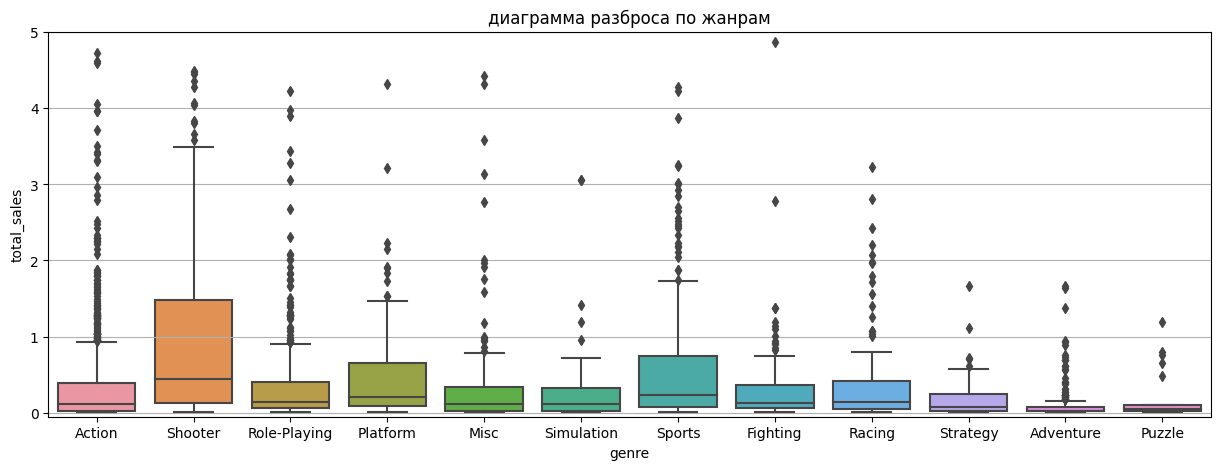

In [48]:
plt.figure(figsize=(15, 5))
plt.ylim(bottom=-0.05, top=5)
plt.grid()
sns.boxplot(data=data_fil_2012, x="genre", y="total_sales");
plt.title('диаграмма разброса по жанрам');

Боксплот подтверждаем нашу гипотезу о высокой цене разработки шутеров, в сравнении с экшенами они более чем в 4 раза уступают им в количестве, но квартили у них выше в несколько раз. 

## Составим портрет пользователя каждого региона

### Построим круговые диаграммы по платформам

#### Составим таблицу топ-5 платформ по глобальным продажам

In [49]:
select_platform = list(pd.pivot_table(data_fil_2012, index="platform",values="total_sales", aggfunc="sum")
                       .sort_values(by="total_sales", ascending=False)
                       .head()
                       .index)
select_platform

['PS4', 'PS3', 'X360', '3DS', 'XOne']

Добавим дополнительный столбец `platform_top_5`

In [50]:
data_fil_2012['platform_top_5'] = data_fil_2012['platform'].where(data_fil_2012['platform'].isin(select_platform), 'Others')

C:\Users\m5612\AppData\Local\Temp\ipykernel_10616\3208353942.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fil_2012['platform_top_5'] = data_fil_2012['platform'].where(data_fil_2012['platform'].isin(select_platform), 'Others')


In [51]:
top_5_plat_reg = data_fil_2012.pivot_table(index='platform_top_5', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc="sum")
top_5_plat_reg                         

,eu_sales,jp_sales,na_sales
platform_top_5,,,
3DS,42.64,87.79,55.31
Others,90.12,51.63,90.37
PS3,106.86,35.29,103.38
PS4,141.09,15.96,108.74
X360,74.52,1.57,140.05
XOne,51.59,0.34,93.12


In [52]:
data_fil_2012.shape

(2886, 13)

#### Строим графики

У нас будет несколько однотипных графиков, создадим функцию:

In [53]:
def func_plot (df, suptitle):
    # подписи к графикам
    region_titles = ["Северная Америка", "Евросоюз", "Япония"]

    # столбцы сводной таблицы, по которым строим диаграммы
    region_sales =["na_sales", "eu_sales", "jp_sales"]

    # кол-во регионов (= кол-во отдельных графиков)
    n_regions = len(region_sales)

    # определяем области для отрисовки графиков (1 строка, 3 столбца, размер (20 x 10))
    _, axes = plt.subplots(nrows=1, ncols=n_regions, figsize=(20, 10))

    # отрисовываем продажи для каждого региона по отдельности
    for ax, sales_col, title in zip(axes, region_sales, region_titles):
        df.plot.pie(y=sales_col, legend=False, ylabel="", 
                       autopct='%1.1f%%',
                       shadow=True, startangle=0, figsize=(20,5), title=title, ax=ax);

    # добавляем подпись ко всему графику
    plt.suptitle(suptitle);

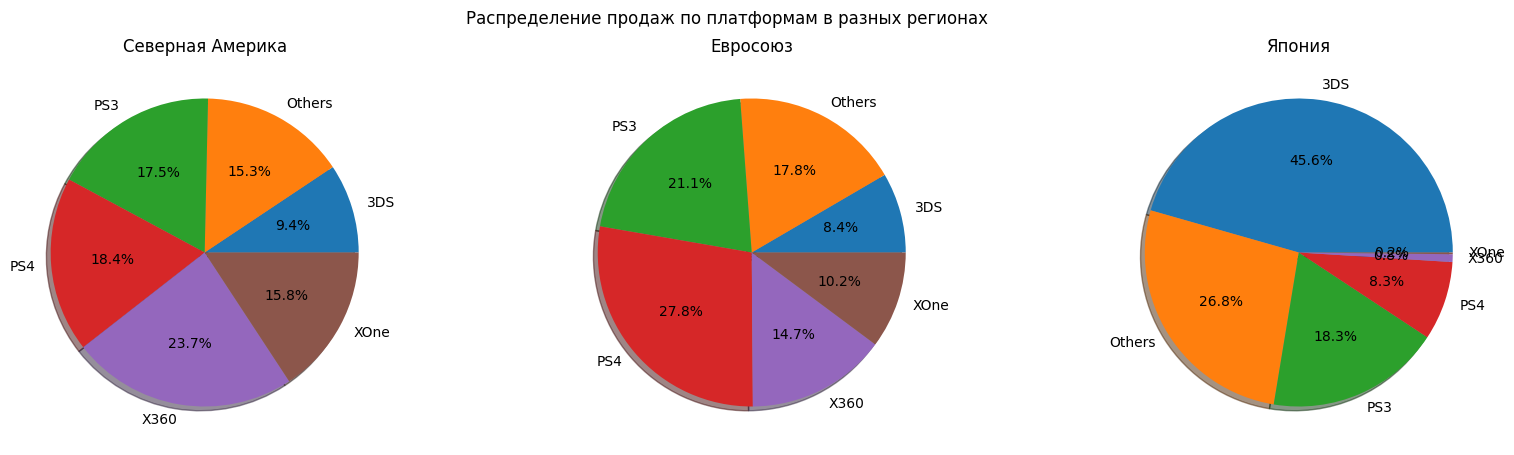

In [54]:
func_plot(top_5_plat_reg, "Распределение продаж по платформам в разных регионах")

In [55]:
top_5_plat_reg.sum()

eu_sales    506.82
jp_sales    192.58
na_sales    590.97
dtype: float64

**Вывод**  
В топ 5 у нас 2 американские (2 поколения от Microsoft) и 3 японские платформы (2 поколения от Sony и последнее поколение Nintendo).  
В Америке Microsoft на равных конкурирует с Sony, хотя теряет долю рынка в последнем поколении консолей.  
В Европе Sony пользуется бОльшей популярностью и увеличивает долю рынка за счет Microsoft.  
В Японии американские консоли эксклюзив, необычайно большую долю рынка занимает Nintendo (45% против 9 в европе и америке) и сильно проседает PS4. Также выделяется большая доля категории 'Others', вероятно топ-5 платформ в Японии будет другим.

### Построим круговые диаграммы по жанрам

In [56]:
select_genre = list(pd.pivot_table(data_fil_2012, index="genre", values="total_sales", aggfunc="sum")
                    .sort_values(by="total_sales", ascending=False)
                    .head()
                    .index)
select_genre

['Action', 'Shooter', 'Role-Playing', 'Sports', 'Misc']

Добавим дополнительный столбец `genre_top_5`

In [57]:
data_fil_2012['genre_top_5'] = data_fil_2012['genre'].where(data_fil_2012['genre'].isin(select_genre), 'Others')

C:\Users\m5612\AppData\Local\Temp\ipykernel_10616\859848726.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fil_2012['genre_top_5'] = data_fil_2012['genre'].where(data_fil_2012['genre'].isin(select_genre), 'Others')


In [58]:
top_5_genre_reg = data_fil_2012.pivot_table(index='genre_top_5', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc="sum")
top_5_genre_reg

,eu_sales,jp_sales,na_sales
genre_top_5,,,
Action,159.34,52.80,177.84
Misc,26.32,12.86,38.19
Others,90.07,44.24,84.64
Role-Playing,48.53,65.44,64.00
Shooter,113.47,9.23,144.77
Sports,69.09,8.01,81.53


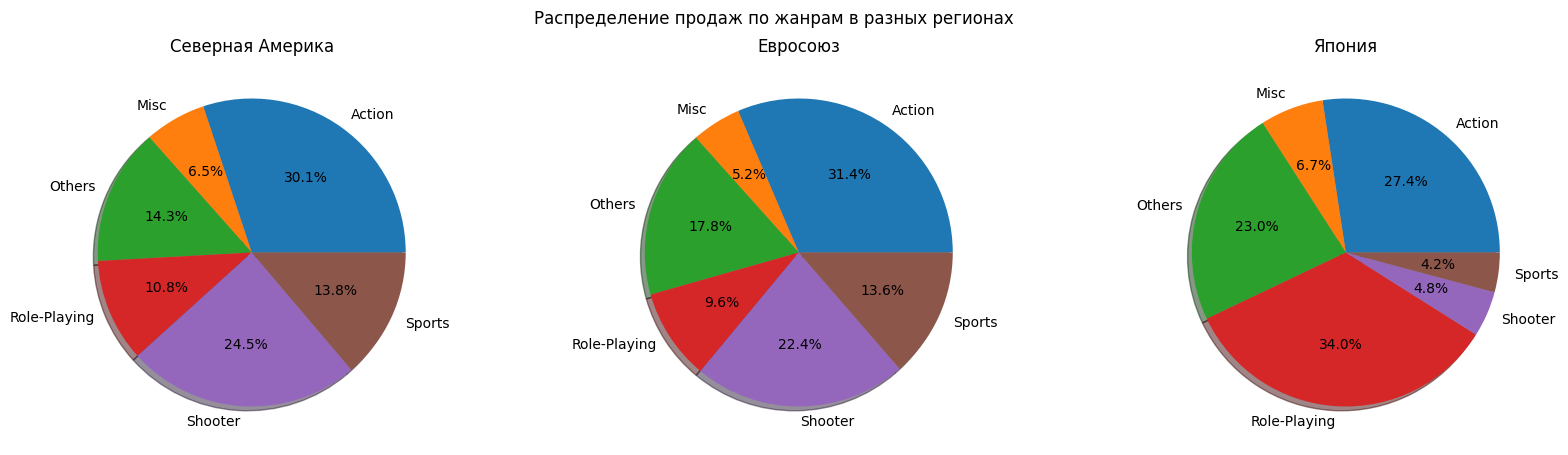

In [59]:
func_plot(top_5_genre_reg, "Распределение продаж по жанрам в разных регионах")

**Вывод**  
По жанрам в Европе и Америке предпочтения похожи, половина игр относятся к жанрам 'Action', 'Shooter'.  
Япония сильно отличается. Ролевые игры на первом месте (34%), а 'Shooter' и  'Sports' просели до 4%, 'Action' потерял 4%.


### Влияние рейтинга ESRB на продажи в отдельном регионе

In [60]:
esrb_reg = data_fil_2012.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc="sum")
esrb_reg

,eu_sales,jp_sales,na_sales
rating,,,
E,113.03,28.33,114.37
E10+,55.37,8.19,75.70
M,193.96,21.20,231.57
T,52.96,26.02,66.02
unknown,91.50,108.84,103.31


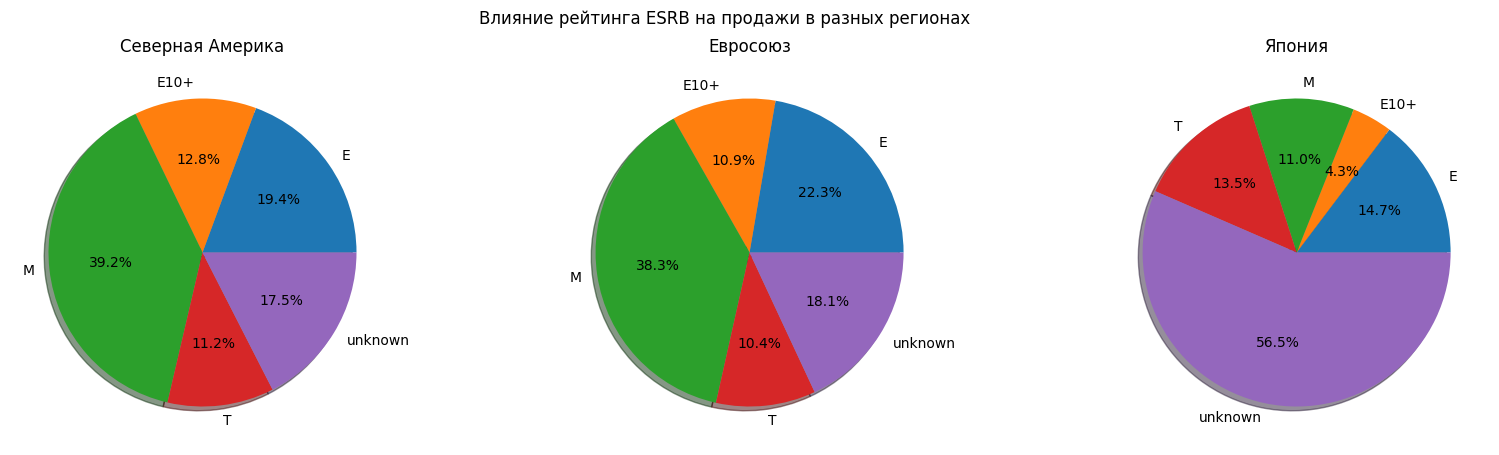

In [61]:
func_plot(esrb_reg, "Влияние рейтинга ESRB на продажи в разных регионах")

Расшифровка обозначений:  
- «E» («Everyone») — «Для всех»
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет. 
- «M» («Mature») — «Для взрослых»: Материалы игры не подходят для лиц младше 17 лет.

Entertainment Software Rating Board (ESRB) — негосударственная организация, основное направление деятельности — принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде.  

В Японии 56% рейтинг не присвоен, вероятно это объясняется  наличием японской рейтинговой организацией CERO, игры для внутрияпонского рынка на касаются ESRB.  

Посмотрим на график без учета пропусков:

In [62]:
esrb_reg_no_unk = esrb_reg.drop(index="unknown")
esrb_reg_no_unk

,eu_sales,jp_sales,na_sales
rating,,,
E,113.03,28.33,114.37
E10+,55.37,8.19,75.70
M,193.96,21.20,231.57
T,52.96,26.02,66.02


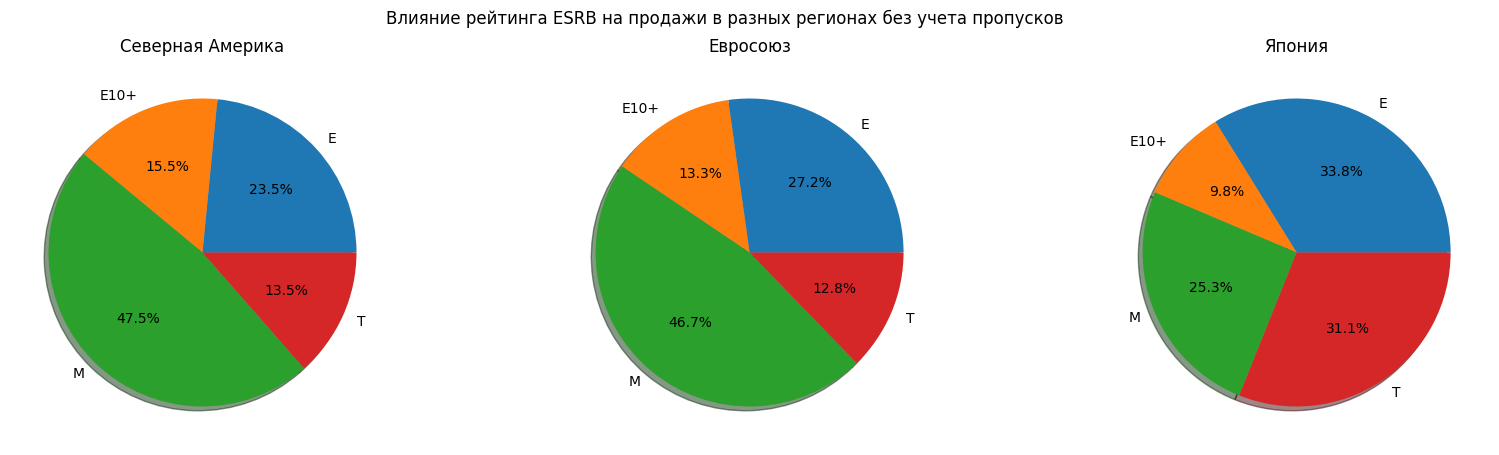

In [63]:
func_plot(esrb_reg_no_unk, "Влияние рейтинга ESRB на продажи в разных регионах без учета пропусков")

По рейтингу в Европе и Америке распределения похожи, почти половина игр для взрослых, на четверть игр нет ограничений, 13% для подростков.  
В Японии опять существенные отличия: четверть игр для взрослых, треть для всех и почти треть для подростков (разница 20%).

## Проверим гипотезы

### Проверим гипотезу: Средние пользовательские рейтинги платформ _Xbox One_ и _PC_ одинаковые.

Для проверки гипотезы о равенстве среднего двух генеральных совокупностей используем t-тест.  
- _Нулевая гипотеза H₀_ - средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- _Альтернативная гипотеза H₁_ - средние пользовательские рейтинги платформ Xbox One и PC различаются.

Пороговое значение alpha примем равным 0.05

Напишем  функцию:

In [64]:
def func_ttest(sample1, sample2, equal_var = True ):
    alpha = .05 # критический уровень статистической значимости
    # если p-value окажется меньше него - отвергнем гипотезу

    results = ttest_ind(
        sample1, 
        sample2,
        equal_var = equal_var)

    print('p-значение:', results.pvalue)

    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу") 

Создадим выборки:

In [65]:
sample_xone = data.loc[data['platform'] == 'XOne']['user_score'].dropna().astype(float)
sample_pc = data.loc[data['platform'] == 'PC']['user_score'].dropna().astype(float)
print('Размер выборки по платформе XOne:', len(sample_xone))
print('Среднее выборки по платформе XOne:', sample_xone.mean().round(2))
print('Размер выборки по платформе PC:', len(sample_pc))
print('Среднее выборки по платформе PC:', sample_pc.mean().round(2))

Размер выборки по платформе XOne: 182
Среднее выборки по платформе XOne: 6.52
Размер выборки по платформе PC: 770
Среднее выборки по платформе PC: 7.06


выборки сильно различаются по размеру — укажем параметр `equal_var = False` при вызове метода

In [66]:
func_ttest(sample_xone, sample_pc, False)

p-значение: 4.935072360183574e-06
Отвергаем нулевую гипотезу


**Вывод**  
У нас появились основания предполагать, что гипотеза "Средние пользовательские рейтинги за все время наблюдений одинаковые" не верна, вероятно у платформы Xbox One рейтинги ниже, чем у платформы PC.

Проверим еще одну гипотезу: выборки взятые за похожие временные периоды, могут изменить наш вывод.
Выше представленные выборки не учитывают разные временные периоды оценок этих платформ (pc уже больше 30 лет, Xbox One вышла в 2012 году), сравним выборки за актуальный период.

In [67]:
sample_xone_2012 = data_fil_2012.loc[data['platform'] == 'XOne']['user_score'].dropna().astype(float)
sample_pc_2012 = data_fil_2012.loc[data['platform'] == 'PC']['user_score'].dropna().astype(float)

In [68]:
print('Размер выборки по платформе XOne:', len(sample_xone_2012))
print('Среднее выборки по платформе XOne:', sample_xone_2012.mean().round(2))
print('Размер выборки по платформе PC:', len(sample_pc_2012))
print('Среднее выборки по платформе PC:', sample_pc_2012.mean().round(2))

Размер выборки по платформе XOne: 182
Среднее выборки по платформе XOne: 6.52
Размер выборки по платформе PC: 206
Среднее выборки по платформе PC: 6.43


In [69]:
func_ttest(sample_xone_2012, sample_pc_2012)

p-значение: 0.5535080500643661
Не получилось отвергнуть нулевую гипотезу


**Вывод**  
Предыдущий вывод ошибочен, мы можем предположить гипотезу изменения среднего рейтинга во времени. Опровергнуть гипотезу "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые" не удалось.

### Проверим гипотезу: Средние пользовательские рейтинги жанров _Action_ и _Sports_  разные

Для проверки гипотезы о равенстве среднего двух генеральных совокупностей используем t-тест.  
- _Нулевая гипотеза H₀_ - средние пользовательские рейтинги жанров _Action_ и _Sports_ одинаковые;
- _Альтернативная гипотеза H₁_ - средние пользовательские рейтинги жанров _Action_ и _Sports_ различаются.


In [70]:
sample_action = data_fil_2012.loc[data['genre'] == 'Action']['user_score'].dropna().astype(float)
sample_sports = data_fil_2012.loc[data['genre'] == 'Sports']['user_score'].dropna().astype(float)
print('Размер выборки по жанру Action:', len(sample_action))
print('Среднее выборки по жанру Action:', sample_action.mean().round(2))
print('Размер выборки по жанру Sports:', len(sample_sports))
print('Среднее выборки по жанру Sports:', sample_sports.mean().round(2))

Размер выборки по жанру Action: 523
Среднее выборки по жанру Action: 6.83
Размер выборки по жанру Sports: 195
Среднее выборки по жанру Sports: 5.46


In [71]:
func_ttest(sample_action, sample_sports)

p-значение: 3.716308946093486e-26
Отвергаем нулевую гипотезу


**Вывод**  
Мы принимаем гипотезу: средние пользовательские рейтинги жанров Action и Sports разные.

## Общий вывод

Цель нашего исследования: выявить определяющие успешность игры закономерности.

- Мы выявили слабую корреляцию продаж с оценкой критиков, этого недостаточно чтобы использовать только оценку критиков в прогнозах, но при хороших оценках вероятность успеха игры повышается. Оценка пользователей нам не пригодится.

- По выбору платформы. На Европейском и Американском рынках мы видим двух лидеров PS4 и XOne, это достаточно новые платформы и они на пике продаж. На японском рынке лидирует 3DS и PS4. Выбирая игры для этих платформ мы можем рассчитывать на широкий круг пользователей.

- По жанрам в Европе и Америке предпочитают 'Action', 'Shooter'. В Японии ролевые игры и 'Action'.

- Почти половину рынка занимают игры с рейтингом "М"

- Гипотеза об отсутствии разницы в пользовательских оценках между платформами Xbox One и PC подтвердилась.
- Гипотеза о разнице в пользовательских оценках между жанрами Action и Sports подтвердилась.

Мы не выявили надежных показателей успеха игры по имеющейся информации, но по оценке критиков мы можем отсечь заведомо провальные игры. А также не рассматривать игры не пользующихся популярностью платформ и жанров.